### BEiT: Bidirectional Encoder Representation from Image Transformer

In [1]:
import os
from PIL import Image
import time
import torch
from torchvision import transforms
from torch.utils.data import Dataset, DataLoader
from transformers import BeitForImageClassification, AdamW, get_scheduler
from torch.utils.data import DataLoader
from torch.nn import CrossEntropyLoss
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
import seaborn as sns
from sklearn.metrics import roc_curve, roc_auc_score, precision_recall_curve, auc
import matplotlib.pyplot as plt

#### Dataset

In [2]:
class FoldDataset(Dataset):
    def __init__(self, root_dir, section, transform=None):
        """
        root_dir: Directory with all the folds.
        section: One of 'train', 'test', 'val'.
        transform: PyTorch transforms for preprocessing.
        """
        self.root_dir = root_dir
        self.section = section
        self.transform = transform
        self.samples = []

        # Load images from each fold
        for fold in os.listdir(self.root_dir):
            section_path = os.path.join(self.root_dir, fold, self.section)
            for label in ['normal', 'abnormal']:
                label_path = os.path.join(section_path, label)
                if os.path.exists(label_path):
                    for img in os.listdir(label_path):
                        self.samples.append((os.path.join(label_path, img), 0 if label == 'normal' else 1))

    def __len__(self):
        return len(self.samples)

    def __getitem__(self, idx):
        img_path, label = self.samples[idx]
        image = Image.open(img_path).convert('RGB')
        if self.transform:
            image = self.transform(image)
        return image, label

transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

In [3]:
print(torch.cuda.is_available())

True


#### Model Setup

In [4]:
# Model setup
print("Loading model...")
model = BeitForImageClassification.from_pretrained('microsoft/beit-base-patch16-224')
device = torch.device('cuda')
model.to(device)

Loading model...


BeitForImageClassification(
  (beit): BeitModel(
    (embeddings): BeitEmbeddings(
      (patch_embeddings): BeitPatchEmbeddings(
        (projection): Conv2d(3, 768, kernel_size=(16, 16), stride=(16, 16))
      )
      (dropout): Dropout(p=0.0, inplace=False)
    )
    (encoder): BeitEncoder(
      (layer): ModuleList(
        (0): BeitLayer(
          (attention): BeitAttention(
            (attention): BeitSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=False)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.0, inplace=False)
              (relative_position_bias): BeitRelativePositionBias()
            )
            (output): BeitSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.0, inplace=False)
            )
          )
          (int

#### Optimizer

In [5]:
# Optimizer setup
print("Setting up optimizer...")
optimizer = AdamW(model.parameters(), lr=6e-5)

Setting up optimizer...


/opt/conda/lib/python3.7/site-packages/transformers/optimization.py:415: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  FutureWarning,


#### Dataloader

In [6]:
base_dir = './data'

# DataLoader setup
print("Preparing data loaders...")
train_dataset = FoldDataset(root_dir=base_dir, section='train', transform=transform)
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)

val_dataset = FoldDataset(root_dir=base_dir, section='val', transform=transform)
val_loader = DataLoader(val_dataset, batch_size=64, shuffle=False)

Preparing data loaders...


#### Loss Function

In [7]:
# Loss function
loss_fn = CrossEntropyLoss()

#### Learning Rate Scheduler

In [8]:
# Scheduler setup
print("Configuring scheduler...")
num_training_steps = len(train_loader) * 25  # 25 epochs
num_warmup_steps = int(0.08 * num_training_steps)  # 8% of total steps as warmup
scheduler = get_scheduler(
    "linear",
    optimizer=optimizer,
    num_warmup_steps=num_warmup_steps,
    num_training_steps=num_training_steps
)

Configuring scheduler...


#### Training

In [9]:
# Training loop
def train_one_epoch(model, data_loader, optimizer, loss_fn, scheduler, device):
    model.train()
    total_loss = 0
    for images, labels in data_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images).logits
        loss = loss_fn(outputs, labels)
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        scheduler.step()

        total_loss += loss.item()
    return total_loss / len(data_loader)

# Validation loop
def validate(model, data_loader, loss_fn, device):
    model.eval()
    total_loss = 0
    with torch.no_grad():
        for images, labels in data_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images).logits
            loss = loss_fn(outputs, labels)
            total_loss += loss.item()
    return total_loss / len(data_loader)

# Training and Validation Execution
train_losses = []
val_losses = []
training_time = 0
print("Starting training and validation...")
for epoch in range(25):
    start_time = time.time()
    print(f"Epoch {epoch+1}/{25}")
    train_loss = train_one_epoch(model, train_loader, optimizer, loss_fn, scheduler, device)
    val_loss = validate(model, val_loader, loss_fn, device)
    train_losses.append(train_loss)
    val_losses.append(val_loss)
    end_time = time.time()
    epoch_time = end_time - start_time
    training_time += epoch_time
    print(f'Train Loss: {train_loss}, Val Loss: {val_loss}, Time Taken: {epoch_time:.2f} seconds')
print("Total training time = ", training_time)

Starting training and validation...
Epoch 1/25
Train Loss: 1.1847223443458381, Val Loss: 0.18719215351569501, Time Taken: 815.74 seconds
Epoch 2/25
Train Loss: 0.10919039133291174, Val Loss: 0.1196560800735709, Time Taken: 816.57 seconds
Epoch 3/25
Train Loss: 0.0266788906717679, Val Loss: 0.3200767182249906, Time Taken: 818.03 seconds
Epoch 4/25
Train Loss: 0.012605145543994167, Val Loss: 0.15474316413526104, Time Taken: 816.73 seconds
Epoch 5/25
Train Loss: 0.007481567057583882, Val Loss: 0.17131253335666563, Time Taken: 818.21 seconds
Epoch 6/25
Train Loss: 0.006681851700916931, Val Loss: 0.13849856192614482, Time Taken: 818.77 seconds
Epoch 7/25
Train Loss: 0.006898604778011185, Val Loss: 0.21732402381747284, Time Taken: 817.63 seconds
Epoch 8/25
Train Loss: 0.0006074816660024414, Val Loss: 0.22850409445702466, Time Taken: 818.90 seconds
Epoch 9/25
Train Loss: 0.006386648989282077, Val Loss: 0.16596272351850955, Time Taken: 818.41 seconds
Epoch 10/25
Train Loss: 0.00507854468826921

#### Saving the model

In [10]:
# Save the model
torch.save(model.state_dict(), "models/trained_beit_model.pth")

#### Plots

Plotting the losses...


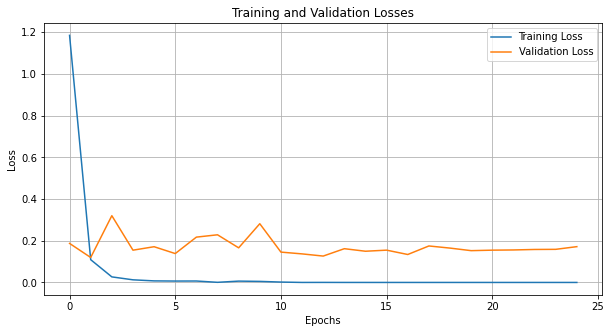

In [11]:
# Plotting the training and validation losses
print("Plotting the losses...")
plt.figure(figsize=(10, 5))
plt.plot(train_losses, label='Training Loss')
plt.plot(val_losses, label='Validation Loss')
plt.title('Training and Validation Losses')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()

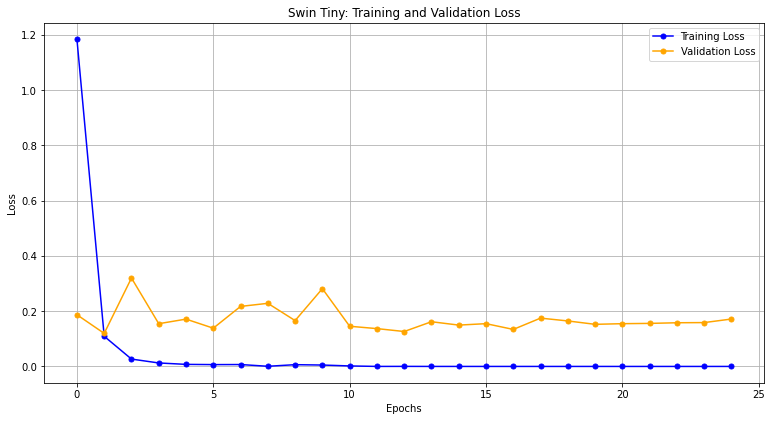

In [12]:
fig = plt.figure(figsize=(10,5)) # make plot
axis = fig.add_axes([0,0,1,1])
axis.plot(train_losses, color='blue', marker='o', ms=5)
axis.plot(val_losses, color='orange', marker='o', ms=5)
axis.set_ylabel("Loss")
axis.set_xlabel("Epochs")

axis.set_title("Swin Tiny: Training and Validation Loss")
axis.grid()

axis.legend(["Training Loss", "Validation Loss"])
plt.show()

In [13]:
# Function to evaluate the model on the validation or test set
def evaluate(model, data_loader, device):
    model.eval()
    y_true = []
    y_pred = []
    with torch.no_grad():
        for images, labels in data_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images).logits
            _, predicted = torch.max(outputs, 1)
            y_true.extend(labels.cpu().numpy())
            y_pred.extend(predicted.cpu().numpy())
    return y_true, y_pred

# Evaluate the model on the validation set
y_true_val, y_pred_val = evaluate(model, val_loader, device)

In [14]:
# Calculate evaluation metrics
accuracy = accuracy_score(y_true_val, y_pred_val)
precision = precision_score(y_true_val, y_pred_val)
recall = recall_score(y_true_val, y_pred_val)
f1 = f1_score(y_true_val, y_pred_val)

print(f'Validation Accuracy: {accuracy:.4f}')
print(f'Precision: {precision:.4f}')
print(f'Recall: {recall:.4f}')
print(f'F1 Score: {f1:.4f}')

Validation Accuracy: 0.9786
Precision: 0.9963
Recall: 0.9561
F1 Score: 0.9758


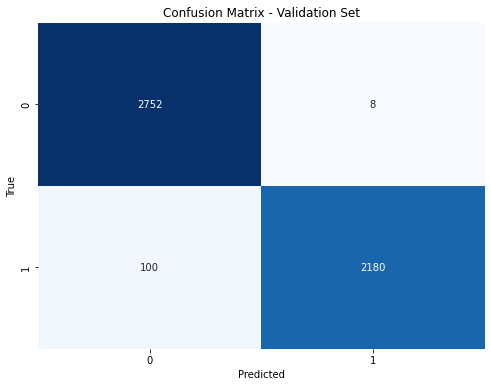

In [15]:
# Confusion Matrix
conf_matrix = confusion_matrix(y_true_val, y_pred_val)

# Plot confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, cmap='Blues', fmt='g', cbar=False)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix - Validation Set')
plt.show()

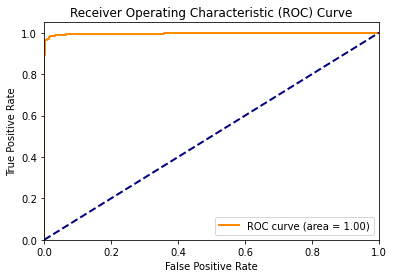

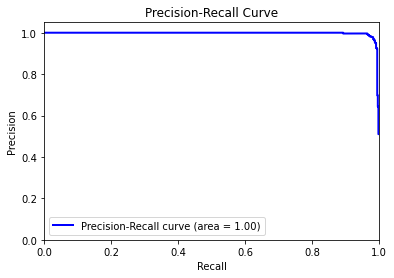

In [16]:
# Function to plot ROC AUC curve
def plot_roc_curve(y_true, y_scores):
    fpr, tpr, _ = roc_curve(y_true, y_scores)
    roc_auc = auc(fpr, tpr)
    plt.figure()
    plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic (ROC) Curve')
    plt.legend(loc="lower right")
    plt.show()

# Function to plot Precision-Recall curve
def plot_precision_recall_curve(y_true, y_scores):
    precision, recall, _ = precision_recall_curve(y_true, y_scores)
    pr_auc = auc(recall, precision)
    plt.figure()
    plt.plot(recall, precision, color='blue', lw=2, label=f'Precision-Recall curve (area = {pr_auc:.2f})')
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.ylim([0.0, 1.05])
    plt.xlim([0.0, 1.0])
    plt.title('Precision-Recall Curve')
    plt.legend(loc="lower left")
    plt.show()

# Function to get predicted probabilities
def predict_probabilities(model, data_loader, device):
    model.eval()
    y_true = []
    y_scores = []
    with torch.no_grad():
        for images, labels in data_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images).logits
            probabilities = torch.nn.functional.softmax(outputs, dim=1)
            y_true.extend(labels.cpu().numpy())
            y_scores.extend(probabilities.cpu().numpy())
    return y_true, y_scores

# Get true labels and predicted probabilities
y_true_val, y_scores_val = predict_probabilities(model, val_loader, device)

# Extract probabilities for the positive class (assuming the positive class is class 1)
y_scores_positive = [score[1] for score in y_scores_val]

# Plot ROC AUC curve
plot_roc_curve(y_true_val, y_scores_positive)

# Plot Precision-Recall curve
plot_precision_recall_curve(y_true_val, y_scores_positive)